In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.optim as optim
from DNN import DeepNet

torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

I'm using:  cuda


In [2]:
def convert(x):
  return x.cpu().detach().numpy()

In [3]:
sol_input = 2 
sol_output = 1
sol_hidden_layer = 5*[40]

coef_input = 1
coef_output = 1
coef_hidden_layer = 5*[40]
activation_function = nn.Tanh()

approx_sol = DeepNet(activation_function,sol_input,sol_hidden_layer,sol_output)
approx_coef = DeepNet(activation_function,coef_input,coef_hidden_layer,coef_output)
print(approx_sol,approx_coef)

DeepNet(
  (activation): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1-4): 4 x Linear(in_features=40, out_features=40, bias=True)
  )
  (output): Linear(in_features=40, out_features=1, bias=False)
) DeepNet(
  (activation): Tanh()
  (hidden): ModuleList(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1-4): 4 x Linear(in_features=40, out_features=40, bias=True)
  )
  (output): Linear(in_features=40, out_features=1, bias=False)
)


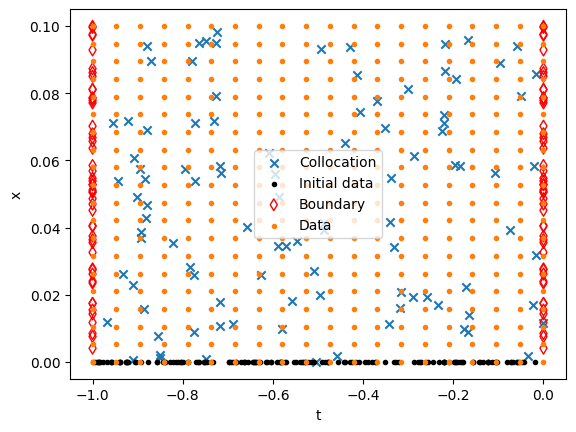

In [4]:
x_ini, x_fin = -1, 0
t_ini, t_fin = 0, 0.1

N_int = 100  # number of collocation points
N_0 = 150  # collocation of the initial data
N_b = 50  # collocation of the boundary coniditon
N_data = 20 # number of data points

x_int = np.random.uniform(x_ini, x_fin, (N_int, 1))
t_int = np.random.uniform(t_ini, t_fin, (N_int, 1))

x_data = torch.linspace(x_ini,x_fin,N_data)
t_data = torch.linspace(t_ini,t_fin,N_data)

data = torch.cartesian_prod(t_data,x_data)

x_0 = np.random.uniform(x_ini, x_fin, (N_0, 1))
t_0 = np.zeros((N_0, 1))


t_b = np.random.uniform(t_ini, t_fin, (N_b, 1))
x_b1 = np.zeros((N_b, 1)) + x_ini
x_b2 = np.zeros((N_b, 1)) + x_fin
# DATA plot
p1 = plt.figure(1)
plt.scatter(x_int, t_int, marker="x",label ='Collocation')
plt.scatter(x_0, t_0, marker=".", c="k",label = 'Initial data')
plt.scatter(x_b1, t_b, marker="d", facecolors="none", edgecolors="r",label = 'Boundary')
plt.scatter(x_b2, t_b, marker="d", facecolors="none", edgecolors="r")
plt.scatter(data[:,1].cpu(),data[:,0].cpu(),marker = '.',label = 'Data')
plt.xlabel("t")
plt.ylabel("x")
plt.legend()

In [5]:
# reshape of the data
x_int = torch.Tensor(x_int).to(device).requires_grad_(True).view(-1, 1)
t_int = torch.Tensor(t_int).to(device).requires_grad_(True).view(-1, 1)

x_0 = torch.Tensor(x_0).to(device).requires_grad_(False).view(-1, 1)
t_0 = torch.Tensor(t_0).to(device).requires_grad_(False).view(-1, 1)

x_data = torch.Tensor(x_data).to(device).requires_grad_(False).view(-1, 1)
t_data = torch.Tensor(t_data).to(device).requires_grad_(False).view(-1, 1)


t_b = torch.Tensor(t_b).to(device).requires_grad_(False).view(-1, 1)
x_b0 = torch.Tensor(x_b1).to(device).requires_grad_(False).view(-1, 1)
x_b1 = torch.Tensor(x_b2).to(device).requires_grad_(False).view(-1, 1)

In [6]:

# Initial condition to solve the heat equation u0(x)=-sin(pi x)
def initial_condition(x):
    return -torch.sin(torch.pi * x)

# Exact solution for the heat equation ut = u_xx with the IC above
def exact_sol(x,t):
    u = -torch.exp(-torch.pi ** 2 * t) * torch.sin(torch.pi * x)
    return u

def exact_conductivity(x):
    k = (torch.sin(torch.pi * x) )
    return k

def source(x,t):
    s = -torch.pi**2*exact_sol(x,t)*(1 - exact_conductivity(x))
    return s

u_exact_data = exact_sol(x_data,t_data)
u_0 = initial_condition(x_0)


In [7]:
def eval_on_xt(Phi, x, t):  # needed for the evalution of the network on two points
    return Phi(torch.cat([x, t], dim=1))

In [8]:
def eval_loss_pde(Phi,Psi,x,t,metric):
    x.requires_grad_(True)
    t.requires_grad_(True)
    
    u = eval_on_xt(Phi,x,t)
    k = Psi(x)
    s = source(x,t)
    u_x = torch.autograd.grad(u.sum(),x,create_graph = True,retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(),x,create_graph = True)[0]
    u_t = torch.autograd.grad(u.sum(),t,create_graph=True)[0]

    return metric(u_t - k*u_xx -s,torch.zeros_like(s))

def eval_loss_pt(Phi,x,t,y):
    return (eval_on_xt(Phi,x,t)-y).pow(2).mean()

def eval_loss_data(Phi,x,t,data,metric):
    return metric(eval_on_xt(Phi,x,t),data)

In [9]:
n_epochs = 6000
optimizer =  optim.Adam(list(approx_sol.parameters())+list(approx_coef.parameters()),lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,100,0.98)

loss_values = np.empty([n_epochs+1,8])# global,pde,t0,b0,b1,data,kb1,kb2
STEP = 100
MSE =  torch.nn.MSELoss()

for epoch in range(n_epochs+1):
  
  loss_pde = eval_loss_pde(approx_sol,approx_coef,x_int,t_int,MSE)
  
  loss_t0 = eval_loss_pt(approx_sol,x_0,t_0,u_0)
  loss_b0 = eval_loss_pt(approx_sol,x_b0,t_b,torch.zeros_like(x_b0))
  loss_b1 = eval_loss_pt(approx_sol,x_b1,t_b,torch.zeros_like(x_b1))
  loss_data = eval_loss_data(approx_sol,x_data,t_data,u_exact_data,MSE)

  loss_k_b1 = approx_coef(x_b0).pow(2).mean()
  loss_k_b2 = approx_coef(x_b1).pow(2).mean()

  loss = 1.5*loss_pde +1.5*loss_t0 + loss_b0 + loss_b1 + loss_data + loss_k_b1 + loss_k_b1 + loss_k_b2

  #print(w_pde,w_t0,w_b1,w_b2,w_data)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  scheduler.step()

  loss_values[epoch,:] = np.stack([convert(loss),convert(loss_pde),convert(loss_t0),convert(loss_b0),convert(loss_b1),convert(loss_data),convert(loss_k_b1),convert(loss_k_b2)])

  if epoch%STEP == 0:

    print(f'Epoch {epoch} | Global loss {loss_values[epoch,0]:.4e} | pde {loss_values[epoch,1]:.4e} | t0 {loss_values[epoch,2]:.4e} | b1 {loss_values[epoch,3]:.4e} | b2 {loss_values[epoch,4]:.4e} | data {loss_values[epoch,5]:.4e} | k boundaries {loss_values[epoch,6]:.4e} {loss_values[epoch,7]:.4e} ')


Epoch 0 | Global loss 1.0571e+02 | pde 6.9899e+01 | t0 4.3713e-01 |b1 5.8685e-03 | b2 2.6026e-07 | data 1.5923e-01 | k boundary 2.0399e-02 0.0000e+00 
Epoch 100 | Global loss 5.0864e+00 | pde 2.8038e+00 | t0 4.9597e-02 |b1 2.8471e-02 | b2 3.9611e-02 | data 3.3303e-02 | k boundary 2.6577e-02 6.5172e-01 
Epoch 200 | Global loss 7.7599e-01 | pde 3.5622e-01 | t0 8.0465e-02 |b1 3.9605e-02 | b2 4.6589e-02 | data 2.6507e-02 | k boundary 4.0606e-03 1.4940e-04 
Epoch 300 | Global loss 4.0424e-01 | pde 9.9741e-02 | t0 9.4420e-02 |b1 3.5955e-02 | b2 4.7972e-02 | data 2.9042e-02 | k boundary 8.4059e-06 1.4330e-05 
Epoch 400 | Global loss 3.2931e-01 | pde 4.9415e-02 | t0 9.7180e-02 |b1 3.7304e-02 | b2 4.2933e-02 | data 2.9077e-02 | k boundary 3.7699e-05 2.5112e-05 
Epoch 500 | Global loss 2.8918e-01 | pde 2.6896e-02 | t0 9.5813e-02 |b1 3.7574e-02 | b2 3.9567e-02 | data 2.7973e-02 | k boundary 1.7564e-07 1.9468e-06 
Epoch 600 | Global loss 2.6261e-01 | pde 1.8656e-02 | t0 9.0496e-02 |b1 3.6037e-02 |

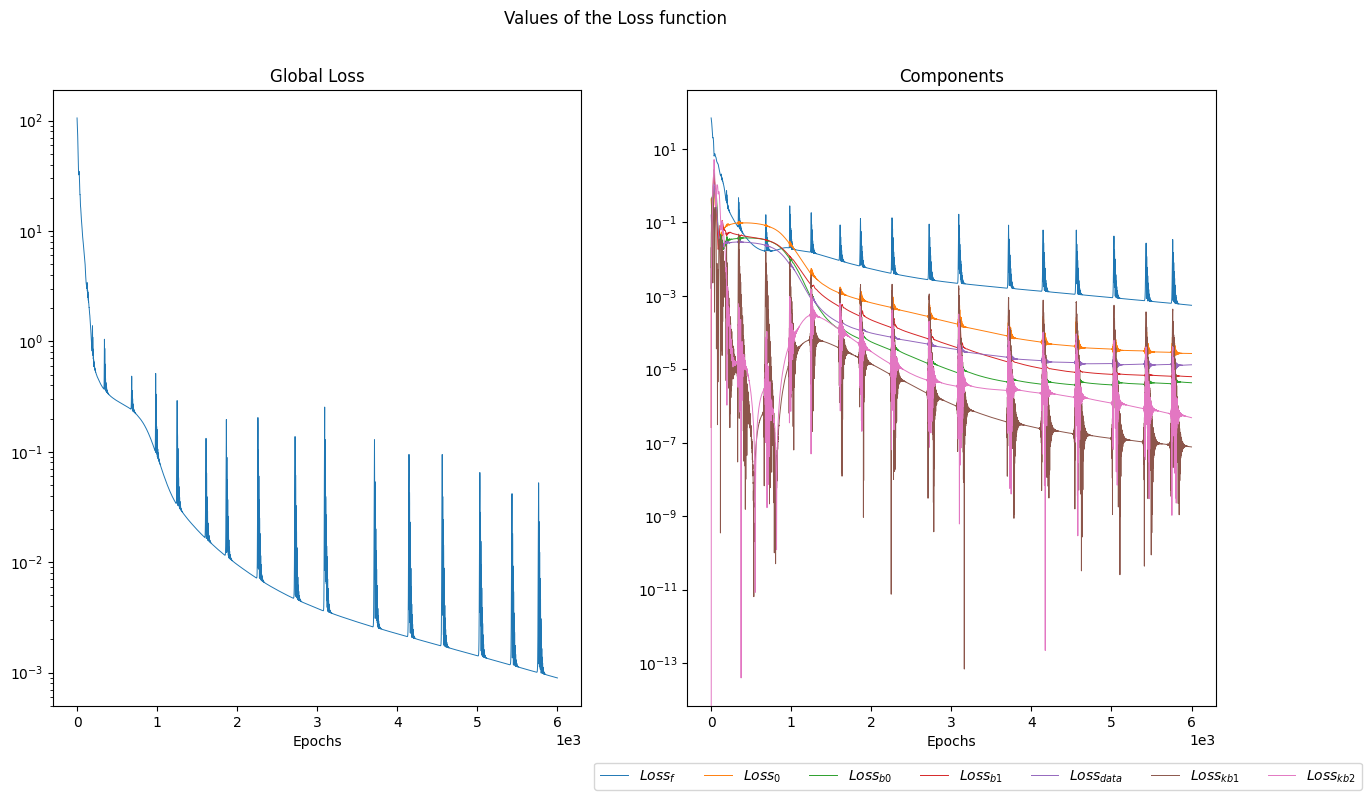

In [10]:
p2 = plt.figure(2, (15, 8))
# global,pde,t0,b0,b1,data,kb1,kb2
e = range(n_epochs + 1)
ax1, ax2 = p2.subplots(1, 2)
ax1.semilogy(e, loss_values[:, 0], linewidth=0.7)
ax1.set_title("Global Loss")
ax1.set_xlabel("Epochs")
ax1.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))

# plt.ylabel('Loss values')
ax2.semilogy(e, loss_values[:, 1], linewidth=0.7, label="$Loss_f$")
ax2.semilogy(e, loss_values[:, 2], linewidth=0.7, label="$Loss_0$")
ax2.semilogy(e, loss_values[:, 3], linewidth=0.7, label="$Loss_{b0}$")
ax2.semilogy(e, loss_values[:, 4], linewidth=0.7, label="$Loss_{b1}$")
ax2.semilogy(e, loss_values[:, 5], linewidth=0.7, label="$Loss_{data}$")
ax2.semilogy(e, loss_values[:, 6], linewidth=0.7, label="$Loss_{kb1}$")
ax2.semilogy(e, loss_values[:, 7], linewidth=0.7, label="$Loss_{kb2}$")
ax2.set_xlabel("Epochs")
ax2.set_title("Components")
ax2.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
p2.legend(loc="lower right", ncol=7)

plt.suptitle("Values of the Loss function")
plt.show()

In [11]:
N_int_tst = 300
N_0_tst = 1000  # same sample for initial data and initial derivate
N_b_tst = 1000

x_test = torch.linspace(x_ini, x_fin, N_int_tst)
t_test = torch.linspace(t_ini, t_fin, N_int_tst)

x_grid, t_grid = torch.meshgrid(x_test, t_test, indexing="ij")
XT = torch.stack([x_grid.ravel(), t_grid.ravel()], axis=-1)

x_0_tst = torch.linspace(x_ini, x_fin, N_0_tst).reshape(1, -1).t()
t_0_tst = torch.zeros_like(x_0_tst)
t_0t_tst = t_0_tst.requires_grad_(True)  # needed for the evaluation of the derivate

t_b_tst = torch.linspace(t_ini, t_fin, N_b_tst).reshape(1, -1).t()
x_b1_tst = torch.zeros_like(t_b_tst)
x_b2_tst = torch.zeros_like(t_b_tst) + x_fin

In [12]:
with torch.inference_mode():
    # Get the model's prediction
    U_theta = convert(eval_on_xt(approx_sol, XT[:, 0:1], XT[:, 1:2]))
    # Reshape U_theta to have the same structure as your grid
    U_theta = U_theta.reshape(x_grid.shape)
    u_ex_tst = convert(exact_sol(x_grid, t_grid))
    x_grid = convert(x_grid)
    t_grid = convert(t_grid)


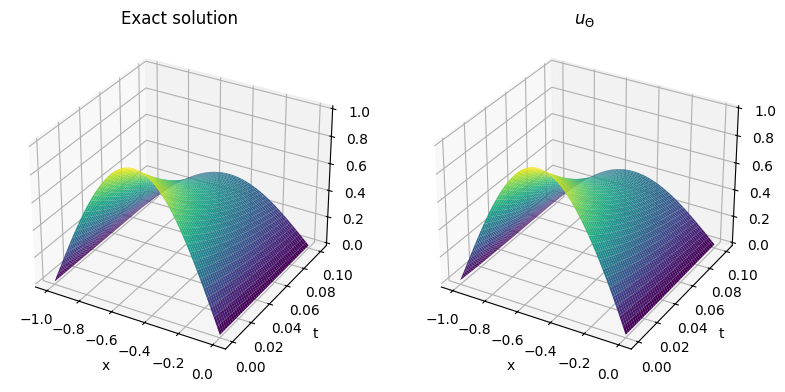

In [13]:
# Plot the surface
p3 = plt.figure(3, figsize=plt.figaspect(0.5))

ax = p3.add_subplot(1, 2, 1, projection="3d")
ax.plot_surface(x_grid, t_grid, u_ex_tst, cmap="viridis")
ax.set_title("Exact solution")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax = p3.add_subplot(1, 2, 2, projection="3d")
ax.plot_surface(x_grid, t_grid, U_theta, cmap="viridis")
ax.set_title(r"$u_{\Theta}$")
ax.set_xlabel("x")
ax.set_ylabel("t")
plt.show()

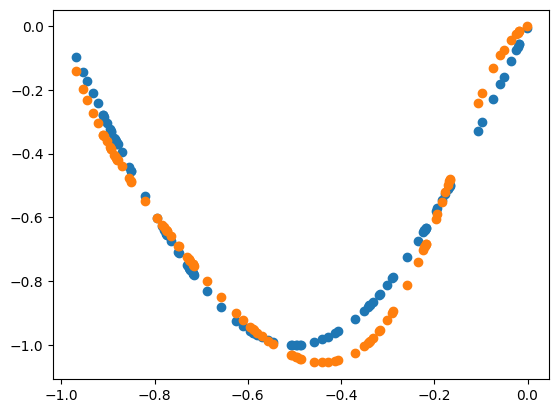

In [14]:
plt.scatter(convert(x_int),convert(exact_conductivity(x_int)))
plt.scatter(convert(x_int),convert(approx_coef(x_int)))